# Data Preprocessing
## Import Packages and Set Up Environment
### Import Core Packages|

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

### Get Current Operating System and Set Paths Dependent on Working OS

In [3]:
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()

# Get Data Directory
basepath = Path(r'E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2')
cur_folder = Path(basepath).name
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)

print('Basepath:', basepath)
print('Working Directory:', cur_folder)
print('Session Name:', session_name)

Basepath: E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2
Working Directory: Stb_2024-10-30_Suzuka_2
Session Name: Stb_Suzuka_2


In [4]:
# Set up environment for windows
if cur_system == "Windows":
    sys.path.extend(['E:\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    save_dir = Path('E:\\Analyses\\Preprocessing')
elif cur_system == "Linux":
    save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    
    # Old Code, just in case new code breaks
    #basepath = os.getcwd()

    #save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    #plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing/Plots')
# Set Session name as folders for notebook outputs
save_dir = Path(save_dir / cur_folder)
plot_dir = Path(save_dir / 'Plots')

save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print('Save Directory:', save_dir)
print('Plot Directory:', plot_dir)

Save Directory: E:\Analyses\Preprocessing\Stb_2024-10-30_Suzuka_2
Plot Directory: E:\Analyses\Preprocessing\Stb_2024-10-30_Suzuka_2\Plots


### Import NeuroPy Packages

In [5]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core import Epoch
from neuropy.core.session import ProcessData

from neuropy.analyses.artifact import detect_artifact_epochs

from neuropy.plotting.signals import plot_signal_w_epochs

from neuropy.io.openephysio import *
from neuropy.io import SpykingCircusIO

from neuropy.io.neuroscopeio import NeuroscopeIO

### Import Session Data

In [6]:
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\Stb_2024-10-30_Suzuka.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 2919.19 seconds 
duration: 0.81 hours 



## Preprocess Ephys Data
- Identify Artifacts
    - Disconnects
    - Filtering
- Send events files to check in Neuroscope
- Write `dead_times.txt` file for spyking-circus and `artifacts.npy` files
### Identify Disconnects and Motion Artifacts

In [9]:
%matplotlib widget

# Parameters
buffer_add = 0.25    # Add buffer before and after detected artifact epochs, None = don't add any
art_thresh = 5     # Artifact detection threshold
art_edge_cutoff = 2  # Edge cutoff value
art_merge = 6    # Merges epochs that are too close to each other

# Plot Parameters
chan_plot = 8

# Get signal object
signal = sess.eegfile.get_signal()

Buffer of 0.25 added before/after each epoch
Artifact File: E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\Stb_Suzuka_2.evt.art
Total artifact time = 222.2 seconds
Automatically detected artifact epochs:
        start       stop label  duration
0      7.6852     8.2812          0.5960
1     16.8204    20.0404          3.2200
2     27.7860    28.2924          0.5064
3     89.7076    90.2620          0.5544
4    300.5436   380.7556         80.2120
5    539.8156   559.3460         19.5304
6    569.6316   570.2188          0.5872
7   1216.2556  1218.7308          2.4752
8   1236.6708  1238.9332          2.2624
9   1246.9244  1249.1860          2.2616
10  1255.7652  1258.0396          2.2744
11  1269.4364  1271.8964          2.4600
12  1282.3092  1284.4692          2.1600
13  1297.5956  1299.9580          2.3624
14  1307.5572  1309.8292          2.2720
15  1324.0556  1326.5292          2.4736
16  1333.1092  1335.2652          2.1560
17  1344.5684  1346.9428          2.3744
18  1359

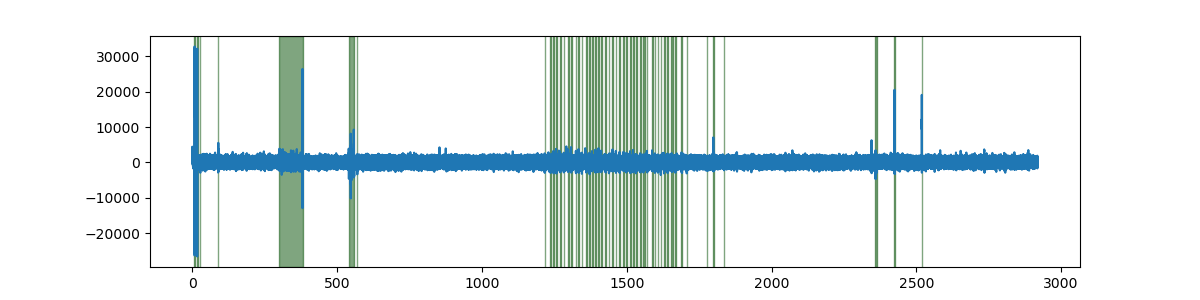

In [ ]:
# Find artifact epochs
art_epochs = detect_artifact_epochs(signal, thresh=art_thresh, edge_cutoff=art_edge_cutoff, merge=art_merge)

# Add in a buffer to prevent erroneous detetion of start/stop of artifact as SWRs.
if buffer_add is not None:
    art_epochs.add_epoch_buffer(buffer_add)

# Plot automatically detected epochs to see how they look
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)

# Save evt.art file to visualize in Neuroscope
sess.recinfo.write_epochs(epochs=art_epochs, ext='art')

ns_art_file = basepath / f"{session_name}.evt.art"
print('Artifact File:', ns_art_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

### Check Events in Neuroscope
- Load evt.art file in Neuroscope and check if it aligns with artifacts in the signal.
- Check if there are any other artifact epochs that were missed by the automatic detection

In [7]:
cur_folder = "Stb_2024-10-30_Suzuka"
ns_art_file = basepath / f"{cur_folder}.evt.art"
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
art_epochs = sess.recinfo.event_to_epochs(ns_art_file)
art_epochs.save(art_epochs_file)
print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Curated artifact epochs:')
print(art_epochs.to_dataframe())

E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\Stb_2024-10-30_Suzuka.art_epochs.npy saved
Total artifact time = 31.9 seconds
Curated artifact epochs:
        start       stop label  duration
0      7.6852     8.2404          0.5552
1     16.8884    20.0404          3.1520
2     27.7862    28.2924          0.5062
3     89.7076    90.2622          0.5546
4    379.9760   380.5904          0.6144
5    540.3644   559.0784         18.7140
6   1777.2084  1777.7204          0.5120
7   1798.6964  1799.4092          0.7128
8   2358.9268  2364.2244          5.2976
9   2424.2902  2424.9582          0.6680
10  2518.4732  2519.0828          0.6096


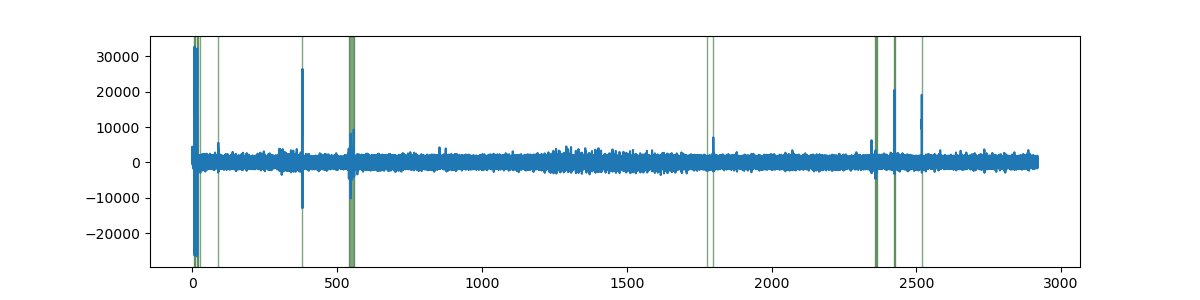

In [10]:
# Plot artifact onto an example channel
chan_plot = 8 # Select a good channel
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)
art_fig_name = f'{session_name}_Artifacts_Channel{chan_plot}.png' 
plt.savefig(plot_dir / art_fig_name, dpi=300, bbox_inches='tight')  # Save with full path

### Identify Stimulation Epochs
- Stimulation will have artifacts that are highly stereotyped

In [11]:
SR = sess.recinfo.dat_sampling_rate

# Get sample numbers for TTL Events
ttl_events = load_all_ttl_events(sess.basepath)

stim_on_events = ttl_events.loc[ttl_events["channel_states"] == 1, "sample_number"]
stim_off_events = ttl_events.loc[ttl_events["channel_states"] == -1, "sample_number"]
stim_art_events = ttl_events.loc[ttl_events["channel_states"].abs() == 1, "sample_number"]

stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")

stim_epochs = Epoch(pd.DataFrame({
    "start": stim_on_events.reset_index(drop=True) / SR, 
    "stop": stim_off_events.reset_index(drop=True) / SR, 
    "label": ""
    }))

stim_epochs_df = stim_epochs.to_dataframe()
stim_epochs_df['time_between'] = stim_epochs_df['start'] - stim_epochs_df['stop'].shift(1)
stim_epochs_df = stim_epochs_df.drop(0)

# Rudimentary Labeling
stim_epochs = Epoch(stim_epochs_df)
sess.recinfo.write_epochs(epochs=stim_epochs, ext='stm')
stim_epochs.save(stim_epochs_file)
stim_epochs_df

E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\Stb_2024-10-30_Suzuka.stim_epochs.npy saved


,start,stop,label,duration,time_between
1,300.847800,300.897800,,0.05,0.004367
2,300.937867,300.987867,,0.05,0.040067
3,301.032200,301.082200,,0.05,0.044333
4,301.127000,301.177000,,0.05,0.044800
5,301.234833,301.284833,,0.05,0.057833
...,...,...,...,...,...
1058,1708.062067,1708.112067,,0.05,0.051533
1059,1708.162400,1708.212400,,0.05,0.050333
1060,1708.263400,1708.313400,,0.05,0.051000
1061,1708.363167,1708.413167,,0.05,0.049767


#### Identify Stimulation Artifacts
Stimulation Artifact can currently be classified in several ways
- TTLs: Timestamps of the stim means we create a buffer around the TTL to determine the artifact.

In [12]:
s_buffer = 0.001
e_buffer = 0.01
buffer_duration = s_buffer + e_buffer

stim_art_epochs_file = sess.filePrefix.with_suffix(".stim_art_epochs.npy")

start_adjusted = pd.DataFrame({
    'start': stim_epochs_df['start'] - s_buffer,
    'stop': stim_epochs_df['start'] + e_buffer,
    'label': 0
})

stop_adjusted = pd.DataFrame({
    'start': stim_epochs_df['stop'] - s_buffer,
    'stop': stim_epochs_df['stop'] + e_buffer,
    'label': 1
})

stim_art_epochs_df = pd.concat([start_adjusted, stop_adjusted]).sort_values(by='start').reset_index(drop=True)
stim_art_epochs = Epoch(stim_art_epochs_df)
sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
stim_art_epochs.save(stim_art_epochs_file)
print(stim_art_epochs_df)

E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\Stb_2024-10-30_Suzuka.stim_art_epochs.npy saved
            start         stop  label
0      300.846800   300.857800      0
1      300.896800   300.907800      1
2      300.936867   300.947867      0
3      300.986867   300.997867      1
4      301.031200   301.042200      0
...           ...          ...    ...
2119  1708.312400  1708.323400      1
2120  1708.362167  1708.373167      0
2121  1708.412167  1708.423167      1
2122  1708.463033  1708.474033      0
2123  1708.513033  1708.524033      1

[2124 rows x 3 columns]


#### Write Stim Artifact to a Trigger Detection File

In [13]:
def format_row(row):
    prefix = int(row['label'])
    start_ms = row['start'] * 1000  # Convert start time to milliseconds
    return f"{prefix} {start_ms:.6f}"

# Apply the function to each row
output = stim_art_epochs_df.apply(format_row, axis=1)

# Save to a text file without index or header
stim_times_filepath = basepath / 'spyk-circ' / 'stim_times.txt'


#stim_times_filepath = basepath + '/spyk-circ/stim_times.txt'
# Create spyk-circ directory
spyk_circ = basepath / 'spyk-circ'
os.makedirs(spyk_circ, exist_ok=True)
output.to_csv(stim_times_filepath, index=False, header=False)

In [77]:
# Create Stim Windows Text File
stim_windows_filepath = spyk_circ / 'stim_windows.txt'
with open(stim_windows_filepath, "w") as file:
    file.write("// Estimated duration of artifacts\n")
    for index, row in stim_window_df.iterrows():
        file.write(f"// Stim {row['label']} lasts {(row['dur']*1000):.6f} ms\n")
    for index, row in stim_window_df.iterrows():
        file.write(f"{int(row['label'])} {(row['dur']*1000):.6f} # Opto \n")


In [76]:
print(stim_window_df)

   label       dur
0      0  0.021974
1      1  0.054994
2      2  0.071433


### Write to Spyking-Circus `dead_times.txt` File
- Text file containing 2 columns, start and stop of artifact epochs that should be ignored by spike sorting algorithm.

In [65]:
sess.filePrefix.with_suffix(".art_epochs.npy")
SpykingCircusIO.write_epochs(spyk_circ / 'dead_times.txt', art_epochs)

dead_times.txt created


In [66]:
import shutil

# Copy .dat file to spyk-circ
source = basepath / (cur_folder + ".dat")
dest = basepath / "spyk-circ" / (cur_folder + ".dat")
shutil.copy(source, dest)
print(f"File copied successfully from {source} to {dest}")


File copied successfully from E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\Stb_2024-10-30_Suzuka.dat to E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka_2\spyk-circ\Stb_2024-10-30_Suzuka.dat


In [67]:
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

log_path = basepath / f"{session_name}_Processing_Log.txt"
log_path.parent.mkdir(parents=True, exist_ok=True)
with open(log_path, 'w') as file:
    file.write(f"Session name: {session_name}\n")
    file.write(f"Datetime: {current_datetime}\n")
    file.write(f"Working OS: {cur_system}\n")
    file.write(f"Basepath: {basepath}\n")
    file.write(f"Working Directory: {cur_folder}\n")
    file.write(f"Session Name: {session_name}\n")
    file.write(f"Save Directory: {save_dir}\n")
    file.write(f"Plot Directory: {plot_dir}\n\n")

    file.write("Artifact Detection Parameters:\n")
    file.write(f"Buffer: {buffer_add}\n")
    file.write(f"Artifact Threshold: {art_thresh}\n")
    file.write(f"Artifact Edge Cutoff: {art_edge_cutoff}\n")
    file.write(f"Artifact Merge Distance: {art_merge}\n")
    file.write(f"Stimulation Artifact Buffer: {buffer}\n\n")